<a href="https://colab.research.google.com/github/Kambey-san/NNWs_Basic/blob/main/PZ_II_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#pip install -U keras-tuner

In [2]:
#TensorFlow and tf.keras
import tensorflow as tf
tf.random.set_seed(5)
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical, to_ordinal
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
#Helper libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras_tuner as kt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, accuracy_score
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization

print(tf.__version__)

2.12.0


<ipython-input-2-c0dfe8ddd683>:16: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization


## Импортируем Fashion MNIST датасет

In [3]:
from keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize. Приводим в единый вид  - насыщенность цветом макс. = 255!
train_images = (train_images / 255) #- 0.5
test_images = (test_images / 255) #- 0.5

# Flatten. "Выпрямляем" тензор (28Х28 = 784)
X_train_images = train_images.reshape((-1, 784)) # можно использовать np.ravel()
X_test_images = test_images.reshape((-1, 784))

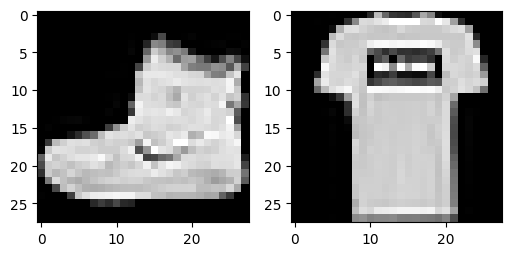

In [4]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(train_images[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(train_images[1], cmap='gray')

Датасет содержит следующие классы:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Каждому классу обозначенному цифрой мы можем присвоить текстовое значение -

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Определение слоев

Cоздадим 3 слоя нейронной сети с помощью функционала **Keras.layers**

In [6]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28), name='input'), # растянутая не получается ((
    keras.layers.Dense(256, activation='relu', name='hiden_one'),
    keras.layers.Dense(128, activation='relu', name='hiden_two'),
    keras.layers.Dense(64, activation='tanh', name='hiden_three'),
    keras.layers.Dense(64, activation='relu', name='hiden_four'),
    keras.layers.Dense(10, name='output')
])
config = model.get_config()
model.save_weights('fashion_weights.h5')

313/313 - 1s - loss: 0.3452 - accuracy: 0.8921 - 770ms/epoch - 2ms/step

Test accuracy: 0.8920999765396118
313/313 [==============================] - 1s 2ms/step


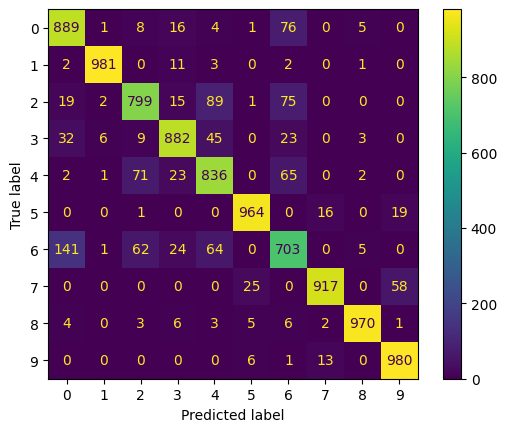

In [7]:
model = model.from_config(config)
model.load_weights('fashion_weights.h5')


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.fit(train_images, train_labels, batch_size = 250, epochs=25, verbose=0)
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)
  # Получим предсказания
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)
# Посмотрим на результаты
ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 784)               0         
                                                                 
 hiden_one (Dense)           (None, 256)               200960    
                                                                 
 hiden_two (Dense)           (None, 128)               32896     
                                                                 
 hiden_three (Dense)         (None, 64)                8256      
                                                                 
 hiden_four (Dense)          (None, 64)                4160      
                                                                 
 output (Dense)              (None, 10)                650       
                                                                 
Total params: 246,922
Trainable params: 246,922
Non-trai

In [9]:
# Evaluate the model.
loss,metrics = model.evaluate(test_images, test_labels)
print(f'Loss - {np.round(loss,2)}, Accuracy - {np.round(metrics,2)}')

313/313 [==============================] - 1s 3ms/step - loss: 0.3452 - accuracy: 0.8921
Loss - 0.35, Accuracy - 0.89


In [10]:
def recall_precision(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
  precision = precision_score(y_true, y_pred, labels=labels, average=None)
  recall = recall_score(y_true, y_pred, labels=labels, average=None)
  for i, el in enumerate(zip(precision, recall)):
    print(f'Класс - {i}, точность - {el[0]:.3f}, полнота - {el[1]:.3f}')

In [11]:
recall_precision(test_labels, y_pred)

Класс - 0, точность - 0.816, полнота - 0.889
Класс - 1, точность - 0.989, полнота - 0.981
Класс - 2, точность - 0.838, полнота - 0.799
Класс - 3, точность - 0.903, полнота - 0.882
Класс - 4, точность - 0.801, полнота - 0.836
Класс - 5, точность - 0.962, полнота - 0.964
Класс - 6, точность - 0.739, полнота - 0.703
Класс - 7, точность - 0.967, полнота - 0.917
Класс - 8, точность - 0.984, полнота - 0.970
Класс - 9, точность - 0.926, полнота - 0.980


Поиграем со слоями...

In [12]:
model_2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28), name='input'),
    keras.layers.Embedding(100000, input_length=100, output_dim=15), # добавим эмбендингов!..
    keras.layers.Dense(256, activation='relu', name='hiden_one'),
    keras.layers.Dropout(0.3),                                     # и Dropout
    keras.layers.Dense(128, activation='relu', name='hiden_two'),
    keras.layers.Dense(64, activation='tanh', name='hiden_three'),
    keras.layers.Dropout(0.5),                                    # и Dropout
    keras.layers.Dense(64, activation='relu', name='hiden_four'),
    keras.layers.Dense(10, activation='softmax', name = 'output')  # + activation='softmax'
])
config = model.get_config()
model.save_weights('fashion_weights_mod2.h5')

313/313 - 1s - loss: 0.5409 - accuracy: 0.8991 - 1s/epoch - 5ms/step

Test accuracy: 0.8991000056266785
313/313 [==============================] - 2s 6ms/step


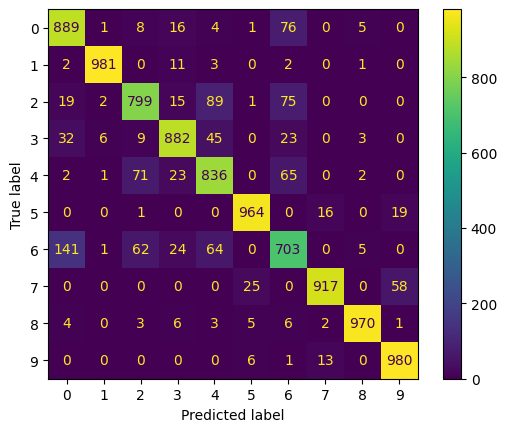

In [13]:
model_2 = model_2.from_config(config)
model_2.load_weights('fashion_weights_mod2.h5')


model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model_2.fit(train_images, train_labels, batch_size = 250, epochs=50, verbose=0)

test_loss, test_acc = model_2.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)
  # Получим предсказания
probability_model_2 = tf.keras.Sequential([model_2,
                                         tf.keras.layers.Softmax()])
predictions_2 = probability_model_2.predict(test_images)
y_pred = np.argmax(predictions, axis=1)
# Посмотрим на результаты
ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)

In [14]:
# Evaluate the model_2.
loss,metrics = model_2.evaluate(test_images, test_labels)
print(f'Loss - {np.round(loss,2)}, Accuracy - {np.round(metrics,2)}')

313/313 [==============================] - 2s 5ms/step - loss: 0.5409 - accuracy: 0.8991
Loss - 0.54, Accuracy - 0.9


**Вывод**: "приседания" с эмбендингами, дропаутами, функциями активации, кратным увеличениями learning_rate и количествами эпох не привели к существенному улучшению model_2 относительно начальной.

## Keras Tuner

In [15]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize. Приводим в единый вид  - насыщенность цветом макс. = 255!
train_images = (train_images / 255) #- 0.5
test_images = (test_images / 255) #- 0.5

# Flatten. "Выпрямляем" тензор (28Х28 = 784)
X_train_images = train_images.reshape((-1, 784)) # можно использовать np.ravel()
X_test_images = test_images.reshape((-1, 784))

In [16]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28), name='input'), # растянутая не получается ((
    keras.layers.Dense(256, activation='relu', name='hiden_one'),
    keras.layers.Dense(128, activation='relu', name='hiden_two'),
    keras.layers.Dense(64, activation='tanh', name='hiden_three'),
    keras.layers.Dense(64, activation='relu', name='hiden_four'),
    keras.layers.Dense(10, name='output')
])
config = model.get_config()
model.save_weights('fashion_weights.h5')

In [17]:
model = model.from_config(config)
model.load_weights('fashion_weights.h5')


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.fit(train_images, train_labels, batch_size = 256, epochs=25, verbose=0)
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

313/313 - 1s - loss: 0.3395 - accuracy: 0.8943 - 694ms/epoch - 2ms/step


In [18]:
def build_model(hp):
    model = Sequential()
    activation_choice = hp.Choice('activation', values=['relu', 'sigmoid', 'tanh', 'elu', 'selu'])
    model.add(Dense(units=hp.Int('units_input',      # Полносвязный слой с разным количеством нейронов
                                   min_value=128,    # минимальное количество нейронов - 128
                                   max_value=1024,   # максимальное количество - 1024
                                   step=32),
                    input_dim=784,
                    activation=activation_choice))
    model.add(Dense(units=hp.Int('units_hidden',
                                   min_value=128,
                                   max_value=600,
                                   step=32),
                    activation=activation_choice))
    model.add(Dense(10, activation='softmax'))
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam','rmsprop','SGD']),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [19]:
# Создаем tuner
tuner = BayesianOptimization(
    build_model,                 # функция создания модели
    objective='val_accuracy',    # метрика, которую нужно оптимизировать -
                                 # доля правильных ответов на проверочном наборе данных
    max_trials=80,               # максимальное количество запусков обучения
    directory='test_directory_1'   # каталог, куда сохраняются обученные сети
    )

In [20]:
# Запускаем подбор гиперпараметров     ...что-то пошло не так...
tuner.search_space_summary(model)

Search space summary
Default search space size: 4
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh', 'elu', 'selu'], 'ordered': False}
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 512, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
units_hidden (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop', 'SGD'], 'ordered': False}


In [21]:
tuner.search(train_images,             # Данные для обучения
             train_labels,
             batch_size=256,           # Размер мини-выборки
             epochs=25,                # Количество эпох обучения
             validation_split=0.2,     # Часть данных, которая будет использоваться для проверки
             )

Trial 11 Complete [00h 00m 01s]

Best val_accuracy So Far: None
Total elapsed time: 00h 00m 02s

Search: Running Trial #12

Value             |Best Value So Far |Hyperparameter
relu              |sigmoid           |activation
544               |640               |units_input
224               |384               |units_hidden
rmsprop           |adam              |optimizer

Epoch 1/25


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    rais

RuntimeError: ignored